In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
from torch.autograd import Variable

device = torch.device("cuda",0)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

# Cross species : HPP

In [2]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
#         print(outputs.argmax(dim=1),
#              outputs.argmax(dim=1)==y,
#              (outputs.argmax(dim=1)==y).float(),
#              (outputs.argmax(dim=1)==y).float().sum(),
#              (outputs.argmax(dim=1)==y).float().sum().item())
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(4050,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)

In [3]:
net = newModel().to(device)
net.load_state_dict(torch.load(f'RefModel/2021ACS_PepFormer/Model/0.pl')['model'])

<All keys matched successfully>

In [4]:
df_hpp = pd.read_csv('/data/2021_SJH_detectability/data_human/HPP.csv')[['peptide', 'Class']]
df_hpp = df_hpp.loc[df_hpp.peptide.apply(len)<=79].reset_index(drop=True)
hpp_class = np.array(df_hpp['Class'].values)
df_hpp['Class'] = df_hpp.Class.apply(lambda x: {'PE1': str(1), 'Detected_MPs': str(1), 'MPs': str(0)}[x])

In [4]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
##############################################
# original code
    # with open(file, 'r') as inf:
    #     lines = inf.read().splitlines()
##############################################        
    lines = file
    long_pep_counter=0
    pep_codes=[]
    labels=[]
    lines.append('X'*79+',-1')  # for setting format
    for pep in lines:
        pep,label=pep.split(",")
        if not len(pep) > max_len:
            labels.append(int(label))
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > {}:".format(max_len),long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes, batch_first=True)  # padding
    return data, torch.tensor(labels)

In [6]:
hpp = []
for line in df_hpp.values:
    line = ','.join(line)
    hpp.append(line)
hpp_data, hpp_label = genData(hpp, 79)
hpp_data = hpp_data[:-1]
hpp_label = hpp_label[:-1]
hpp_dataset = Data.TensorDataset(hpp_data, hpp_label)

batch_size=256
hpp_iter = torch.utils.data.DataLoader(hpp_dataset, batch_size=batch_size, shuffle=False)

print('Making predictions')
y_prob = np.array(pred_prob(hpp_iter, net))[:, 1]

length > 79: 0
Making predictions


In [7]:
df_hpp = pd.concat([df_hpp, pd.DataFrame(y_prob, columns=['probs'])], axis=1)

df_hpp['Class'] = hpp_class
min_val = df_hpp.probs.min()
max_val = df_hpp.probs.max()
df_hpp['probs'] = df_hpp.probs.apply(lambda x: (x-min_val)/(max_val-min_val))

pe = df_hpp.loc[df_hpp.Class=='PE1'][['peptide', 'probs']].drop_duplicates()
dmp = df_hpp.loc[df_hpp.Class=='Detected_MPs'][['peptide', 'probs']].drop_duplicates()
mp = df_hpp.loc[df_hpp.Class=='MPs'][['peptide', 'probs']].drop_duplicates()

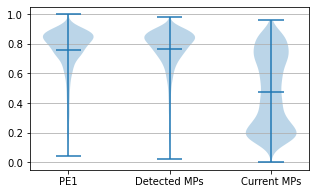

In [8]:
plt.figure(figsize=(5,3))
a = plt.violinplot([pe.probs.astype(float), 
                    dmp.probs.astype(float), 
                    mp.probs.astype(float)],
               showmeans=True,
              )
plt.xticks([y + 1 for y in range(len([pe,dmp,mp]))], ['PE1', 'Detected MPs', 'Current MPs'])
b = plt.grid(axis='y')
plt.show()

TEST Accuracy : 0.8310058866497658
TEST AUC : 0.8309232336701081
              precision    recall  f1-score   support

           0     0.7589    0.5409    0.6316      6234
           1     0.8480    0.9371    0.8904     17039

    accuracy                         0.8310     23273
   macro avg     0.8035    0.7390    0.7610     23273
weighted avg     0.8242    0.8310    0.8211     23273



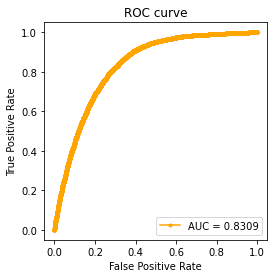

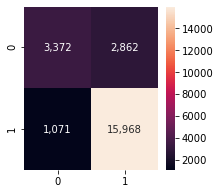

In [9]:
hpp_prob = np.concatenate([pe.probs.values, dmp.probs.values, mp.probs.values])
hpp_pred = np.array([1 if _ >= 0.5 else 0 for _ in hpp_prob])
hpp_true = np.array([1]*len(pe) + [1]*len(dmp) + [0]*len(mp))

auc = roc_auc_score(hpp_true, hpp_prob)
acc = accuracy_score(hpp_true,hpp_pred)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(hpp_true, hpp_pred, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(hpp_true, hpp_prob)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(hpp_true, hpp_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [10]:
np.save('log/result_HPP_PepFormer_fpr.npy', fpr)
np.save('log/result_HPP_PepFormer_tpr.npy', tpr)
np.save('log/result_HPP_PepFormer_threshold.npy', threshold)
np.save('log/result_HPP_PepFormer_prob.npy', hpp_prob)
np.save('log/result_HPP_PepFormer_true.npy', hpp_true)

# Cross species : Mouse

length > 79: 0
Test AUC : 0.8331598547118834
              precision    recall  f1-score   support

           0     0.9984    0.5461    0.7060   1436852
           1     0.1045    0.9835    0.1890     77418

    accuracy                         0.5685   1514270
   macro avg     0.5515    0.7648    0.4475   1514270
weighted avg     0.9527    0.5685    0.6796   1514270



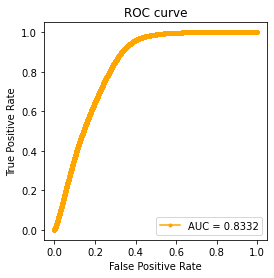

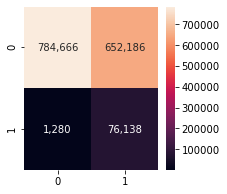

In [12]:
tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/test.csv'),
])[['peptide', 'label']]  # .drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 79)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_KLife_PepFormer_fpr.npy', fpr)
np.save('log/result_mouse_KLife_PepFormer_tpr.npy', tpr)
np.save('log/result_mouse_KLife_PepFormer_threshold.npy', threshold)
np.save('log/result_mouse_KLife_PepFormer_prob.npy', probs)
np.save('log/result_mouse_KLife_PepFormer_true.npy', test_label)

length > 79: 0
Test AUC : 0.8277613276121357
              precision    recall  f1-score   support

           0     0.9973    0.5478    0.7071   1385973
           1     0.1120    0.9743    0.2009     81135

    accuracy                         0.5714   1467108
   macro avg     0.5546    0.7610    0.4540   1467108
weighted avg     0.9483    0.5714    0.6791   1467108



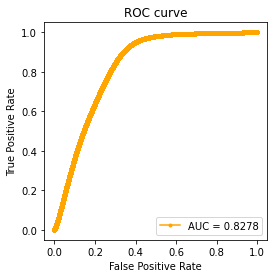

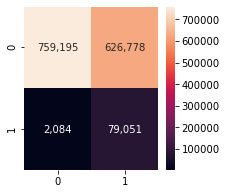

In [6]:
tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/mouse_eph4/data.csv')[['peptide', 'label']]  # .drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 79)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_msgf_KLife_PepFormer_fpr.npy', fpr)
np.save('log/result_mouse_msgf_KLife_PepFormer_tpr.npy', tpr)
np.save('log/result_mouse_msgf_KLife_PepFormer_threshold.npy', threshold)
np.save('log/result_mouse_msgf_KLife_PepFormer_prob.npy', probs)
np.save('log/result_mouse_msgf_KLife_PepFormer_true.npy', test_label)

length > 79: 0
Test AUC : 0.8247735024024605
              precision    recall  f1-score   support

           0     0.9973    0.5460    0.7056   1257928
           1     0.1057    0.9730    0.1906     69344

    accuracy                         0.5683   1327272
   macro avg     0.5515    0.7595    0.4481   1327272
weighted avg     0.9507    0.5683    0.6787   1327272



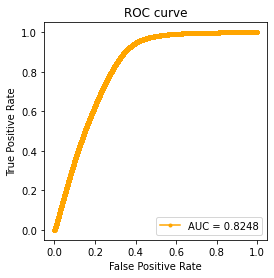

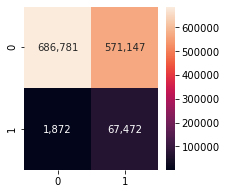

In [13]:
tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/test.csv'),
])[['peptide', 'label']]  # .drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 79)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_SkeletaMuscle_PepFormer_fpr.npy', fpr)
np.save('log/result_mouse_SkeletaMuscle_PepFormer_tpr.npy', tpr)
np.save('log/result_mouse_SkeletaMuscle_PepFormer_threshold.npy', threshold)
np.save('log/result_mouse_SkeletaMuscle_PepFormer_prob.npy', probs)
np.save('log/result_mouse_SkeletaMuscle_PepFormer_true.npy', test_label)

length > 79: 0
Test AUC : 0.8176719360399799
              precision    recall  f1-score   support

           0     0.9960    0.5456    0.7050   1265207
           1     0.1060    0.9613    0.1910     70913

    accuracy                         0.5677   1336120
   macro avg     0.5510    0.7535    0.4480   1336120
weighted avg     0.9488    0.5677    0.6777   1336120



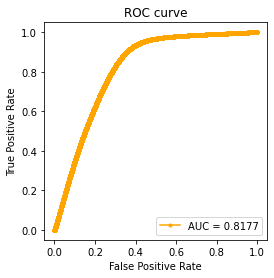

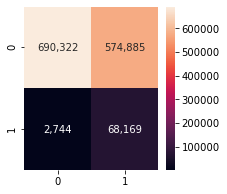

In [7]:
tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/mouse_tmuscle/data.csv')[['peptide', 'label']]  # .drop_duplicates()
tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 79)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_msgf_SkeletaMuscle_PepFormer_fpr.npy', fpr)
np.save('log/result_mouse_msgf_SkeletaMuscle_PepFormer_tpr.npy', tpr)
np.save('log/result_mouse_msgf_SkeletaMuscle_PepFormer_threshold.npy', threshold)
np.save('log/result_mouse_msgf_SkeletaMuscle_PepFormer_prob.npy', probs)
np.save('log/result_mouse_msgf_SkeletaMuscle_PepFormer_true.npy', test_label)

# Cross species : Human

length > 79: 0
Test AUC : 0.8136893732874465
              precision    recall  f1-score   support

           0     0.9955    0.5550    0.7126   1862789
           1     0.1341    0.9648    0.2355    133071

    accuracy                         0.5823   1995860
   macro avg     0.5648    0.7599    0.4741   1995860
weighted avg     0.9381    0.5823    0.6808   1995860



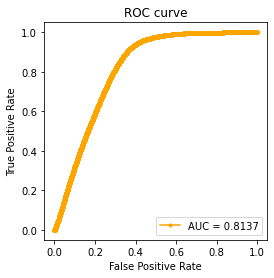

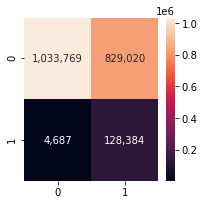

In [14]:
tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 79)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HEK293_PepFormer_fpr.npy', fpr)
np.save('log/result_human_HEK293_PepFormer_tpr.npy', tpr)
np.save('log/result_human_HEK293_PepFormer_threshold.npy', threshold)
np.save('log/result_human_HEK293_PepFormer_prob.npy', probs)
np.save('log/result_human_HEK293_PepFormer_true.npy', test_label)

length > 79: 0
Test AUC : 0.8127688692616476
              precision    recall  f1-score   support

           0     0.9947    0.5567    0.7139   1723461
           1     0.1423    0.9611    0.2479    131848

    accuracy                         0.5855   1855309
   macro avg     0.5685    0.7589    0.4809   1855309
weighted avg     0.9341    0.5855    0.6808   1855309



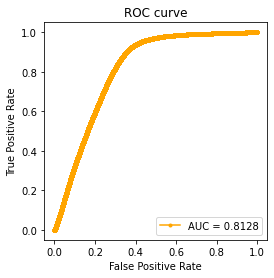

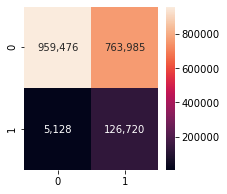

In [8]:
tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/human_hek293/data.csv')[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 79)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_msgf_HEK293_PepFormer_fpr.npy', fpr)
np.save('log/result_human_msgf_HEK293_PepFormer_tpr.npy', tpr)
np.save('log/result_human_msgf_HEK293_PepFormer_threshold.npy', threshold)
np.save('log/result_human_msgf_HEK293_PepFormer_prob.npy', probs)
np.save('log/result_human_msgf_HEK293_PepFormer_true.npy', test_label)

length > 79: 0
Test AUC : 0.7979706306478834
              precision    recall  f1-score   support

           0     0.9965    0.5371    0.6980   1441079
           1     0.0746    0.9516    0.1383     56470

    accuracy                         0.5528   1497549
   macro avg     0.5355    0.7444    0.4182   1497549
weighted avg     0.9617    0.5528    0.6769   1497549



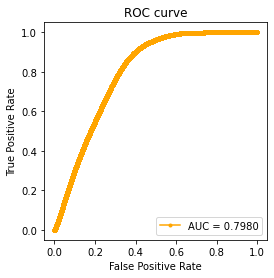

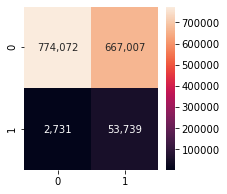

In [15]:
tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 79)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HmapLiver_PepFormer_fpr.npy', fpr)
np.save('log/result_human_HmapLiver_PepFormer_tpr.npy', tpr)
np.save('log/result_human_HmapLiver_PepFormer_threshold.npy', threshold)
np.save('log/result_human_HmapLiver_PepFormer_prob.npy', probs)
np.save('log/result_human_HmapLiver_PepFormer_true.npy', test_label)

length > 79: 0
Test AUC : 0.8063501026873556
              precision    recall  f1-score   support

           0     0.9966    0.5418    0.7019   1125108
           1     0.0909    0.9617    0.1661     53621

    accuracy                         0.5609   1178729
   macro avg     0.5438    0.7517    0.4340   1178729
weighted avg     0.9554    0.5609    0.6776   1178729



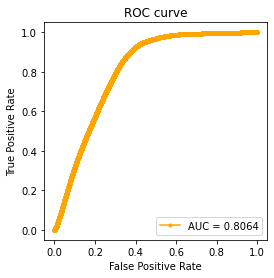

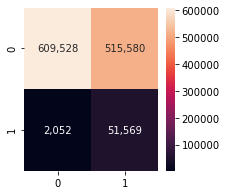

In [9]:
tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/human_liver/data.csv')[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 79)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_msgf_HmapLiver_PepFormer_fpr.npy', fpr)
np.save('log/result_human_msgf_HmapLiver_PepFormer_tpr.npy', tpr)
np.save('log/result_human_msgf_HmapLiver_PepFormer_threshold.npy', threshold)
np.save('log/result_human_msgf_HmapLiver_PepFormer_prob.npy', probs)
np.save('log/result_human_msgf_HmapLiver_PepFormer_true.npy', test_label)

# Cross species : Yeast

length > 79: 0
Test AUC : 0.8304964458095894
              precision    recall  f1-score   support

           0     0.9947    0.5415    0.7013    521986
           1     0.1168    0.9546    0.2082     33160

    accuracy                         0.5662    555146
   macro avg     0.5558    0.7481    0.4547    555146
weighted avg     0.9423    0.5662    0.6718    555146



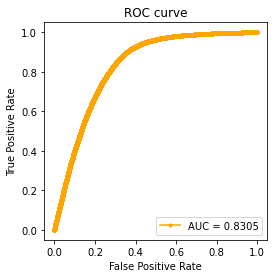

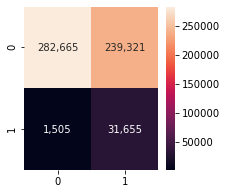

In [16]:
tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 79)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_DelPBP1_PepFormer_fpr.npy', fpr)
np.save('log/result_yeast_DelPBP1_PepFormer_tpr.npy', tpr)
np.save('log/result_yeast_DelPBP1_PepFormer_threshold.npy', threshold)
np.save('log/result_yeast_DelPBP1_PepFormer_prob.npy', probs)
np.save('log/result_yeast_DelPBP1_PepFormer_true.npy', test_label)

length > 79: 0
Test AUC : 0.8006053780935073
              precision    recall  f1-score   support

           0     0.9900    0.5381    0.6973    556165
           1     0.1079    0.9113    0.1929     34086

    accuracy                         0.5597    590251
   macro avg     0.5489    0.7247    0.4451    590251
weighted avg     0.9391    0.5597    0.6681    590251



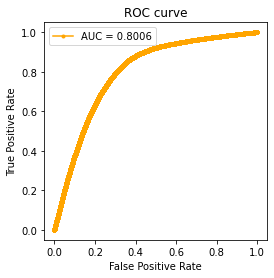

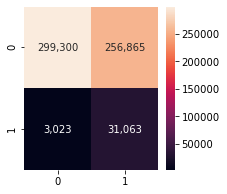

In [10]:
tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/yeast_25/data.csv')[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 79)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_msgf_DelPBP1_PepFormer_fpr.npy', fpr)
np.save('log/result_yeast_msgf_DelPBP1_PepFormer_tpr.npy', tpr)
np.save('log/result_yeast_msgf_DelPBP1_PepFormer_threshold.npy', threshold)
np.save('log/result_yeast_msgf_DelPBP1_PepFormer_prob.npy', probs)
np.save('log/result_yeast_msgf_DelPBP1_PepFormer_true.npy', test_label)

length > 79: 0
Test AUC : 0.8369266088522029
              precision    recall  f1-score   support

           0     0.9930    0.5801    0.7324    562874
           1     0.2438    0.9705    0.3897     78520

    accuracy                         0.6279    641394
   macro avg     0.6184    0.7753    0.5611    641394
weighted avg     0.9013    0.6279    0.6904    641394



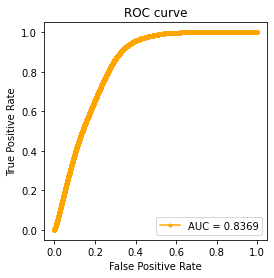

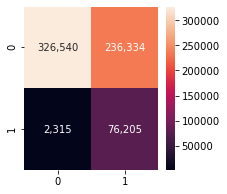

In [17]:
tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/test.csv'),
])[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 79)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_KLife_PepFormer_fpr.npy', fpr)
np.save('log/result_yeast_KLife_PepFormer_tpr.npy', tpr)
np.save('log/result_yeast_KLife_PepFormer_threshold.npy', threshold)
np.save('log/result_yeast_KLife_PepFormer_prob.npy', probs)
np.save('log/result_yeast_KLife_PepFormer_true.npy', test_label)

length > 79: 0
Test AUC : 0.8311731872892081
              precision    recall  f1-score   support

           0     0.9901    0.5835    0.7343    558429
           1     0.2569    0.9612    0.4054     83636

    accuracy                         0.6327    642065
   macro avg     0.6235    0.7723    0.5698    642065
weighted avg     0.8946    0.6327    0.6915    642065



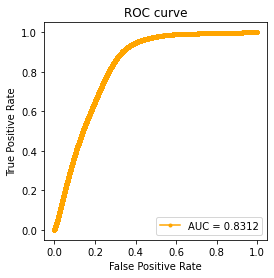

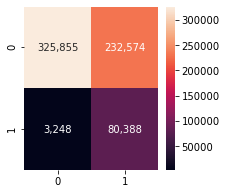

In [11]:
tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/yeast_23/data.csv')[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 79)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_msgf_KLife_PepFormer_fpr.npy', fpr)
np.save('log/result_yeast_msgf_KLife_PepFormer_tpr.npy', tpr)
np.save('log/result_yeast_msgf_KLife_PepFormer_threshold.npy', threshold)
np.save('log/result_yeast_msgf_KLife_PepFormer_prob.npy', probs)
np.save('log/result_yeast_msgf_KLife_PepFormer_true.npy', test_label)

# massIVE-KB

In [18]:
from RefModel.model_PepFormer import newModel, evaluate_accuracy, genData

In [19]:
net_re = newModel().to(device)
net_re.load_state_dict(torch.load(f'log/model_PepFormer.pl')['model'])
net_re.eval()

newModel(
  (embedding): Embedding(24, 512, padding_idx=0)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=Fals

In [20]:
tmp = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv')[['peptide', 'label']]#.drop_duplicates()
tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 40: 0


In [21]:
y_pred = pred(test_iter, net_re)
probs = np.array(pred_prob(test_iter, net_re))[:, 1]

acc = evaluate_accuracy(test_iter,net_re)
auc = roc_auc_score(test_label, probs)

Test Accuracy: 0.8303984628542641
Test AUC : 0.9082578385719137
              precision    recall  f1-score   support

           0     0.8379    0.8249    0.8313     86495
           1     0.8230    0.8361    0.8295     84211

    accuracy                         0.8304    170706
   macro avg     0.8304    0.8305    0.8304    170706
weighted avg     0.8305    0.8304    0.8304    170706



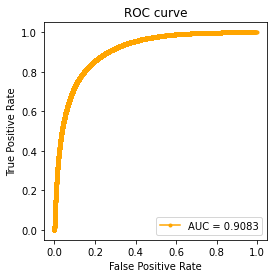

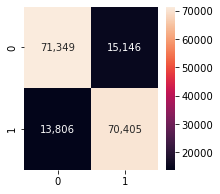

In [22]:
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [16]:
np.save('log/result_PepFormer_fpr.npy', fpr)
np.save('log/result_PepFormer_tpr.npy', tpr)

In [23]:
np.save('log/result_massivekb_ypred_PepFormer.npy', np.array(y_pred))
np.save('log/result_massivekb_yprob_PepFormer.npy', np.array(probs))
np.save('log/result_massivekb_ytrue_PepFormer.npy', np.array(test_label))

# Case of cleavage site count

Test AUC : 0.8692366689065514
              precision    recall  f1-score   support

           0     0.8075    0.5677    0.6667     10970
           1     0.8904    0.9629    0.9252     40007

    accuracy                         0.8778     50977
   macro avg     0.8489    0.7653    0.7960     50977
weighted avg     0.8725    0.8778    0.8696     50977



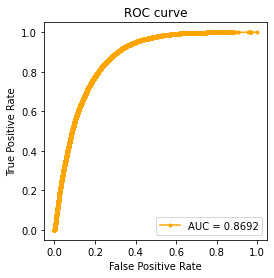

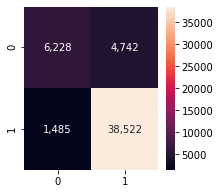

Test AUC : 0.8536561116875439
              precision    recall  f1-score   support

           0     0.7797    0.7433    0.7611     31745
           1     0.7652    0.7993    0.7819     33229

    accuracy                         0.7720     64974
   macro avg     0.7724    0.7713    0.7715     64974
weighted avg     0.7723    0.7720    0.7717     64974



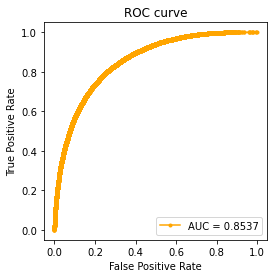

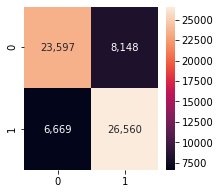

Test AUC : 0.8725826408913484
              precision    recall  f1-score   support

           0     0.8802    0.9485    0.9131     43780
           1     0.7023    0.4850    0.5738     10975

    accuracy                         0.8556     54755
   macro avg     0.7913    0.7167    0.7434     54755
weighted avg     0.8445    0.8556    0.8451     54755



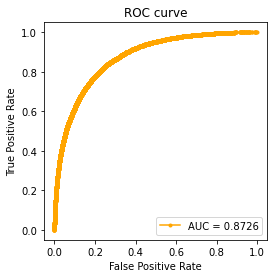

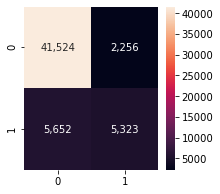

In [17]:
idx = tmp.index
df_test = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv').loc[idx]
df_test.reset_index(drop=True, inplace=True)

miss0_idx = df_test.loc[df_test.miss1=='ZZZZZZZZZZZZZZZ'].index
miss1_idx = df_test.loc[(df_test.miss1!='ZZZZZZZZZZZZZZZ') & (df_test.miss2=='ZZZZZZZZZZZZZZZ')].index
miss2_idx = df_test.loc[(df_test.miss1!='ZZZZZZZZZZZZZZZ') & (df_test.miss2!='ZZZZZZZZZZZZZZZ')].index

y_pred = np.array(y_pred)
probs_miss0 = probs[miss0_idx]
probs_miss1 = probs[miss1_idx]
probs_miss2 = probs[miss2_idx]
y_pred_miss0 = y_pred[miss0_idx]
y_pred_miss1 = y_pred[miss1_idx]
y_pred_miss2 = y_pred[miss2_idx]
test_label_miss0 = test_label[miss0_idx]
test_label_miss1 = test_label[miss1_idx]
test_label_miss2 = test_label[miss2_idx]

auc = roc_auc_score(test_label_miss0, probs_miss0)
print('Test AUC : {}'.format(auc))
print(classification_report(test_label_miss0, y_pred_miss0, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(test_label_miss0, probs_miss0)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label_miss0, y_pred_miss0)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(test_label_miss1, probs_miss1)
print('Test AUC : {}'.format(auc))
print(classification_report(test_label_miss1, y_pred_miss1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(test_label_miss1, probs_miss1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label_miss1, y_pred_miss1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(test_label_miss2, probs_miss2)
print('Test AUC : {}'.format(auc))
print(classification_report(test_label_miss2, y_pred_miss2, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(test_label_miss2, probs_miss2)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label_miss2, y_pred_miss2)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

